# Phân tích khách hàng từ dữ liệu OnlineRetail bằng mô hình RFM và CLV
Trong notebook này, chúng ta sẽ áp dụng các kỹ thuật phân tích dữ liệu để phân khúc và đánh giá giá trị vòng đời khách hàng (CLV) dựa trên dữ liệu giao dịch thực tế.

## Mục tiêu chính:
- Hiểu và tính toán mô hình **RFM (Recency - Frequency - Monetary)**.
- Phân cụm khách hàng dựa trên chỉ số RFM.
- Ước lượng **Customer Lifetime Value (CLV)** từ dữ liệu.
- Phân nhóm khách hàng theo CLV.
- Kết hợp RFM và CLV để phân tích nâng cao.
- Trực quan hóa bằng heatmap để hỗ trợ ra quyết định marketing.

## 1. Tải và tiền xử lý dữ liệu
**Lý thuyết:**
- Dữ liệu giao dịch thường cần được làm sạch: loại bỏ các đơn hàng lỗi, giá trị âm, hoặc thiếu mã khách hàng.
- Tính toán tổng giá trị đơn hàng để phục vụ phân tích.

**Thực hiện:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt

df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## 2. Tính chỉ số RFM
**Lý thuyết:**
- **Recency**: Số ngày kể từ lần mua gần nhất (càng thấp càng tốt).
- **Frequency**: Số lượng đơn hàng (số hóa đơn duy nhất).
- **Monetary**: Tổng số tiền khách chi tiêu.

**Thực hiện:**

In [2]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


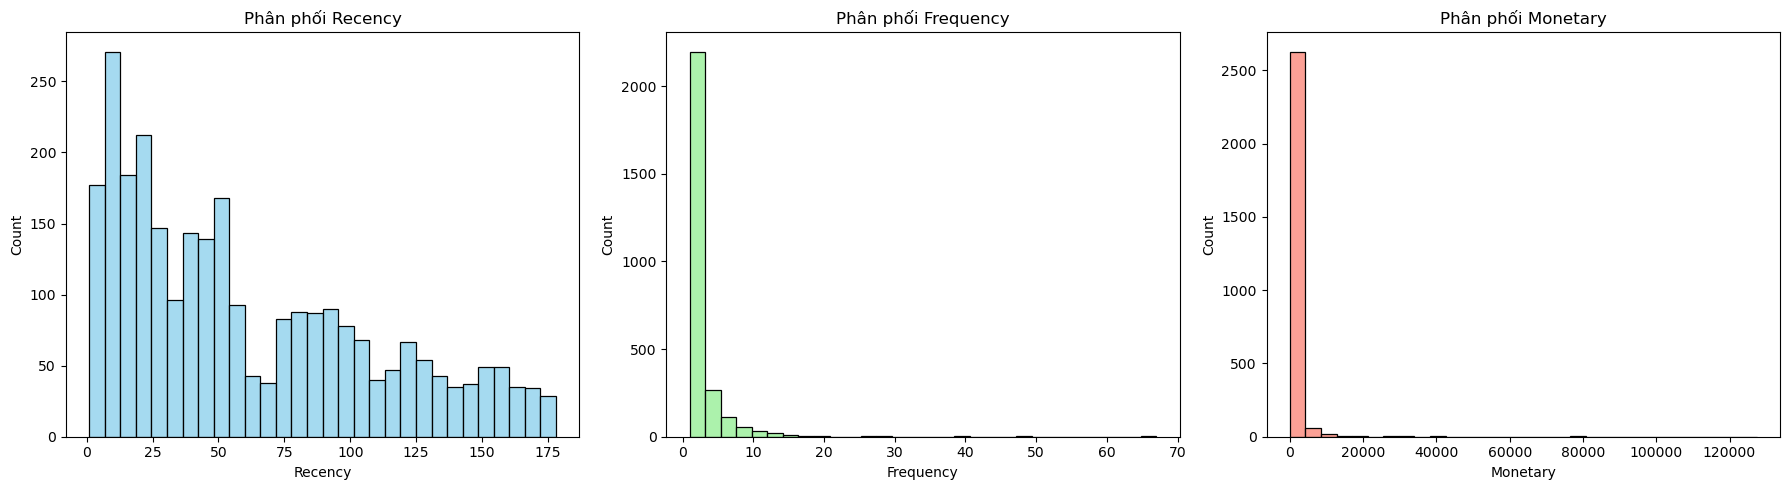

In [3]:
# Trực quan hóa phân phối Recency, Frequency, Monetary
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], bins=30, ax=axs[0], color='skyblue')
axs[0].set_title('Phân phối Recency')
sns.histplot(rfm['Frequency'], bins=30, ax=axs[1], color='lightgreen')
axs[1].set_title('Phân phối Frequency')
sns.histplot(rfm['Monetary'], bins=30, ax=axs[2], color='salmon')
axs[2].set_title('Phân phối Monetary')
plt.tight_layout()
plt.show()

## 3. Phân cụm khách hàng bằng KMeans
**Lý thuyết:**
- KMeans phân nhóm khách hàng thành các cụm dựa trên độ tương đồng RFM.
- Cần chuẩn hóa dữ liệu để tránh ảnh hưởng bởi đơn vị đo lường.

**Thực hiện:**

In [4]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


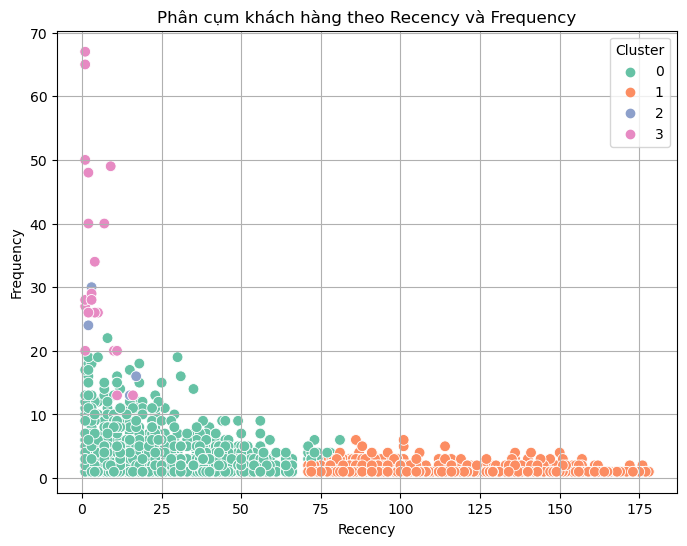

In [5]:
# Trực quan cụm khách hàng (2D: Recency vs Frequency)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2', s=60)
plt.title('Phân cụm khách hàng theo Recency và Frequency')
plt.grid(True)
plt.show()

## 4. Ước lượng Customer Lifetime Value (CLV)
**Lý thuyết:**
$$ CLV = \left( \frac{\text{Average Sales} \times \text{Purchase Frequency}}{\text{Churn Rate}} \right) \times \text{Profit Margin} $$
- Churn rate: tỷ lệ khách hàng không quay lại.
- Lợi nhuận giả định: 10%.

**Thực hiện:**

In [6]:
rfm['AverageSales'] = rfm['Monetary'] / rfm['Frequency']
rfm['PurchaseFrequency'] = rfm['Frequency']
churn_rate = 1 - (rfm['Frequency'] > 1).sum() / len(rfm)
profit_margin = 0.10
rfm['CLV'] = ((rfm['AverageSales'] * rfm['PurchaseFrequency']) / churn_rate) * profit_margin

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


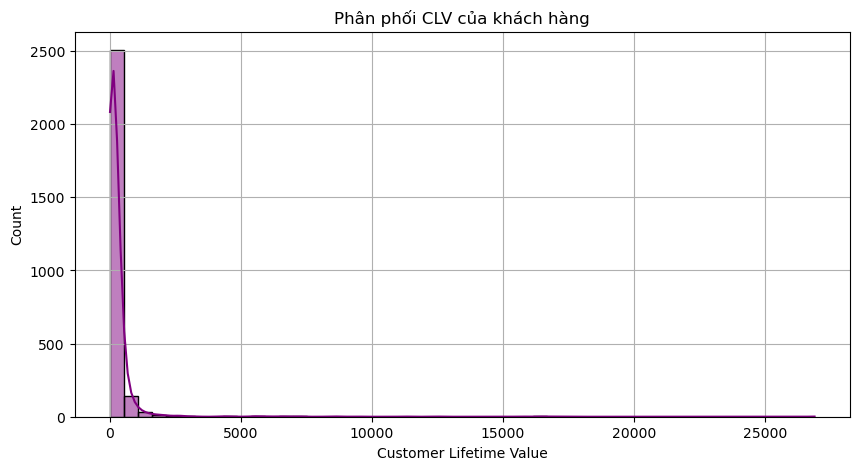

In [7]:
# Trực quan hóa phân phối CLV
plt.figure(figsize=(10, 5))
sns.histplot(rfm['CLV'], bins=50, kde=True, color='purple')
plt.title('Phân phối CLV của khách hàng')
plt.xlabel('Customer Lifetime Value')
plt.grid(True)
plt.show()

## 5. Phân nhóm khách hàng theo CLV
**Lý thuyết:**
- Dùng phân vị để chia thành 3 nhóm: Low, Medium, High CLV.

**Thực hiện:**

In [8]:
rfm['CLV_Segment'] = pd.qcut(rfm['CLV'], q=3, labels=['Low', 'Medium', 'High'])

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


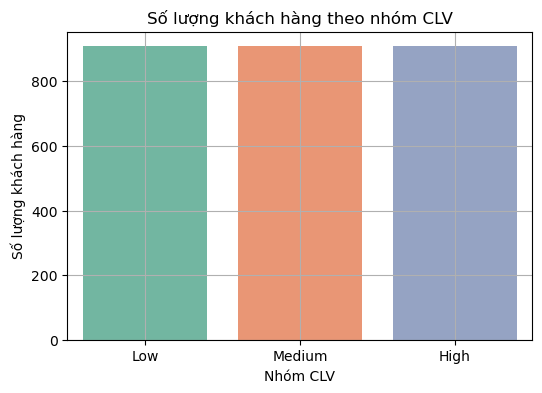

In [9]:
# Biểu đồ số lượng khách hàng theo nhóm CLV
clv_counts = rfm['CLV_Segment'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=clv_counts.index, y=clv_counts.values, palette='Set2')
plt.title('Số lượng khách hàng theo nhóm CLV')
plt.xlabel('Nhóm CLV')
plt.ylabel('Số lượng khách hàng')
plt.grid(True)
plt.show()

## 6. Kết hợp phân cụm RFM và nhóm CLV để phân tích
**Lý thuyết:**
- Tìm hiểu sự khác biệt giữa các nhóm khách hàng bằng cách kết hợp 2 chiều: Cluster và CLV_Segment.

**Thực hiện:**

In [10]:
summary = rfm.groupby(['Cluster', 'CLV_Segment']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CLV': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'}).round(2).reset_index()
summary

C:\Users\Admin\AppData\Local\Temp\ipykernel_16620\1712588374.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = rfm.groupby(['Cluster', 'CLV_Segment']).agg({


,Cluster,CLV_Segment,Recency,Frequency,Monetary,CLV,CustomerCount
0,0,Low,32.21,1.27,186.78,39.41,377
1,0,Medium,31.49,2.16,535.36,112.96,552
2,0,High,25.59,4.83,2156.48,455.02,754
3,1,Low,118.22,1.09,180.01,37.98,531
4,1,Medium,111.41,1.43,482.61,101.83,356
5,1,High,110.00,1.87,1626.27,343.14,126
6,2,Low,NaN,NaN,NaN,NaN,0
7,2,Medium,NaN,NaN,NaN,NaN,0
8,2,High,39.00,12.38,69325.25,14627.57,8
9,3,Low,NaN,NaN,NaN,NaN,0


## 7. Trực quan hóa heatmap
**Lý thuyết:**
- Heatmap giúp nhìn nhanh cụm nào có giá trị cao/thấp.
- Dùng để hỗ trợ ra quyết định marketing.

**Thực hiện:**

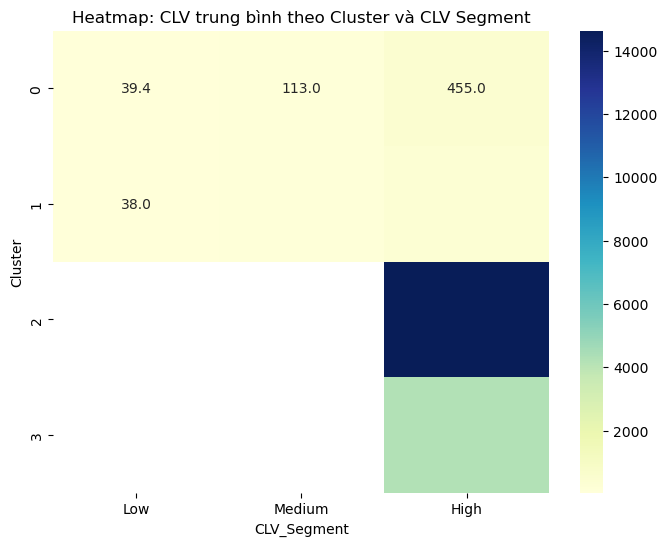

In [11]:
pivot = summary.pivot(index='Cluster', columns='CLV_Segment', values='CLV')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Heatmap: CLV trung bình theo Cluster và CLV Segment')
plt.show()